<a href="https://colab.research.google.com/github/aSafarpoor/OSN_FAD/blob/main/CLS/classifier_part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

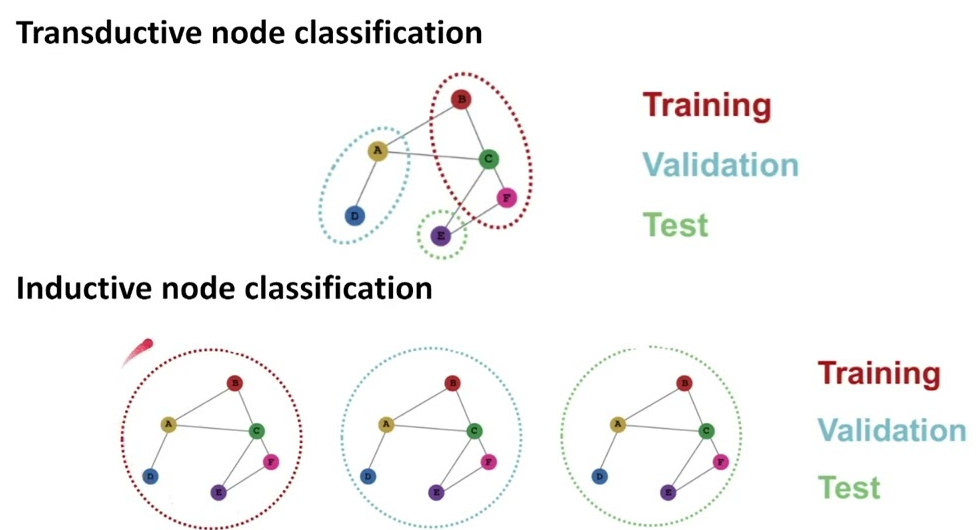

#read data

In [1]:
import numpy as np
import random
from sklearn.metrics import confusion_matrix, accuracy_score
import networkx as nx

In [2]:
def load_txt_file(filename):
	with open(filename, 'r') as file:
		return [int(line.strip()) for line in file]

def load_txt_file_for_edges(filename):
	with open(filename, 'r') as file:
		return [list(map(int,line.strip().split())) for line in file]

In [3]:
def partitioner(x):
    midpoint = len(x) // 2

    # Split the list into two parts
    return x[:midpoint], x[midpoint:]

In [47]:
edges = load_txt_file_for_edges('edges.txt')


bknown = load_txt_file('btrain.txt')
sknown = load_txt_file('strain.txt')

b_known_in_test_phase,btrain = partitioner(bknown)
s_known_in_test_phase,strain = partitioner(sknown)


btest = load_txt_file('btest.txt')
stest = load_txt_file('stest.txt')
nodes = list(set(np.array(edges).reshape(-1)))
num_nodes = len(nodes)

print(len(bknown),len(sknown),len(btest),len(stest))

80 80 323 323


#Transductive

In [6]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.3 MB/s eta 0:00:00


In [27]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import torch_geometric.utils as pyg_utils
from torch_geometric.nn import GATConv
from sklearn.metrics import accuracy_score

from torch_geometric.utils import subgraph
from torch_geometric.nn import SAGEConv
# from torch_geometric.data import HeteroData

In [10]:
# it is not working because bias is false, I don't know why they set it false
class GCN_ETH(torch.nn.Module):
    def __init__(self, num_node_features, num_layers, hidden_width, dropout = True):
        super(GCN_ETH,self).__init__()

        self.dropout = dropout
        self.convs = torch.nn.ModuleList()
        input_width = num_node_features
        self.num_classes = 2
        for i in range(num_layers):
            if i == 0:
                self.convs.append(GCNConv(input_width, hidden_width, bias=False))
            elif i == num_layers - 1:
                self.convs.append(GCNConv(hidden_width, self.num_classes, bias=False))
            else:
                self.convs.append(GCNConv(hidden_width, hidden_width, bias=False))

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        h = x
        i = 0
        for conv in self.convs:
            if self.dropout:
                h = F.dropout(h, p=0.5, training=self.training)
            h = conv(h, edge_index)
            if i < len(self.convs) - 1:
                h = F.tanh(h)
            i += 1

        return F.log_softmax(h, dim=1)


In [11]:
class Edited_GCN_ETH(torch.nn.Module):
    def __init__(self, num_node_features, num_layers, hidden_width, dropout=True):
        super(Edited_GCN_ETH, self).__init__()

        self.dropout = dropout
        self.convs = torch.nn.ModuleList()
        input_width = num_node_features
        self.num_classes = 2  # Assuming binary classification

        for i in range(num_layers):
            if i == 0:
                self.convs.append(GCNConv(input_width, hidden_width, bias=True))
            elif i == num_layers - 1:
                self.convs.append(GCNConv(hidden_width, self.num_classes, bias=True))
            else:
                self.convs.append(GCNConv(hidden_width, hidden_width, bias=True))

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        h = x

        for i, conv in enumerate(self.convs):
            h = conv(h, edge_index)

            if i < len(self.convs) - 1:  # Apply activation and dropout for all but last layer
                h = F.relu(h)
                if self.dropout:
                    h = F.dropout(h, p=0.5, training=self.training)

        return F.log_softmax(h, dim=1)

In [12]:
class GAT_ETH(torch.nn.Module):
    def __init__(self, input_width, num_layers, hidden_width, num_classes, num_heads, dropout: bool = True):
        super().__init__()
        self.dropout = dropout
        self.num_classes = num_classes
        self.convs = torch.nn.ModuleList()

        for i in range(num_layers):
            if i == 0:
                self.convs.append(GATConv(input_width, hidden_width, heads=num_heads))
            elif i == num_layers - 1:
                self.convs.append(GATConv(hidden_width * num_heads, self.num_classes, heads=1))
            else:
                self.convs.append(GATConv(hidden_width * num_heads, hidden_width, heads=num_heads))

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        h = x

        i = 0
        for conv in self.convs:
            if self.dropout:
                h = F.dropout(h, p=0.5, training=self.training)
            h = conv(h, edge_index)
            if i < len(self.convs) - 1:
                h = F.tanh(h)
                # h = F.elu(h)
            i += 1

        return F.log_softmax(h, dim=1)



In [13]:
class GCN1(torch.nn.Module):
    def __init__(self, num_node_features, hidden_dim, num_classes):
        super(GCN1, self).__init__()
        self.conv1 = GCNConv(num_node_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, num_classes)


    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [28]:
class GraphSAGE(torch.nn.Module):
    def __init__(self, num_node_features, hidden_dim, num_classes):
        super(GraphSAGE, self).__init__()
        # Define two SAGEConv layers
        self.conv1 = SAGEConv(num_node_features, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        # First layer: Aggregate features from neighbors
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        # Second layer: Further aggregation and classification
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [14]:
class GCN2(torch.nn.Module):
    def __init__(self, num_node_features, hidden_dim1, hidden_dim2, num_classes):
        super(GCN2, self).__init__()
        self.conv1 = GCNConv(num_node_features, hidden_dim1)
        self.conv2 = GCNConv(hidden_dim1, hidden_dim2)
        self.conv3 = GCNConv(hidden_dim2, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)

        x = self.conv2(x, edge_index)
        x = F.relu(x)

        x = self.conv3(x, edge_index)
        x = F.softmax(x,dim=1)
        return F.log_softmax(x, dim=1)


In [15]:
class GAT1(torch.nn.Module):
    def __init__(self, num_node_features, hidden_dim1, hidden_dim2, num_classes, num_heads=1):
        super(GAT1, self).__init__()
        self.gat1 = GATConv(num_node_features, hidden_dim1, heads=num_heads, concat=True)
        self.gat2 = GATConv(hidden_dim1 * num_heads, hidden_dim2, heads=num_heads, concat=True)
        self.gat3 = GATConv(hidden_dim2 * num_heads, num_classes, heads=1, concat=False)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.gat1(x, edge_index)
        x = F.relu(x)

        x = self.gat2(x, edge_index)
        x = F.relu(x)

        x = self.gat3(x, edge_index)

        return F.log_softmax(x, dim=1)



In [16]:
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(1, 16)
        self.conv2 = GCNConv(16, 2)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x



In [24]:
def main_transductive(model):

    edge_index = torch.tensor([[e[0] for e in edges], [e[1] for e in edges]], dtype=torch.long)  # Replace with actual edges

    labels = torch.tensor([0 if i in btrain or i in btest else 1 if i in strain or i in stest else -1 for i in range(num_nodes)])



    x = torch.zeros((num_nodes, 1))  # 1-dimensional embeddings, all zeros initially


    for node in btrain:
        x[node] = 0  # Benign training nodes
    for node in strain:
        x[node] = 1  # Sybil training nodes
    for node in btest + stest:
        x[node] = 0.5  # Test nodes

    data_train = Data(x=x, edge_index=edge_index, y=labels)


    for node in b_known_in_test_phase:
        x[node] = 0
    for node in s_known_in_test_phase:
        x[node] = 1


    data_test = Data(x=x, edge_index=edge_index, y=labels)


    # Define optimizer and loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    loss_fn = torch.nn.CrossEntropyLoss()

    # Split data into training and testing masks
    train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    test_mask = torch.zeros(num_nodes, dtype=torch.bool)

    # Assign masks for training and testing nodes
    train_mask[btrain + strain] = True
    test_mask[btest + stest] = True

    # Training loop
    def train():
        model.train()
        optimizer.zero_grad()
        out = model(data_train)
        loss = loss_fn(out[train_mask], data_train.y[train_mask])  # Only consider training nodes for loss
        loss.backward()
        optimizer.step()
        return loss.item()

    # Testing function
    def test():
        model.eval()
        out = model(data_test)
        pred = out.argmax(dim=1)  # Get predictions
        train_acc = accuracy_score(data_test.y[train_mask].cpu(), pred[train_mask].cpu())
        test_acc = accuracy_score(data_test.y[test_mask].cpu(), pred[test_mask].cpu())
        return train_acc, test_acc

    # Training the model
    epochs = 100
    for epoch in range(epochs):
        loss = train()
        train_acc, test_acc = test()
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

    # Final evaluation
    train_acc, test_acc = test()
    print(f'Final Train Accuracy: {train_acc:.4f}, Final Test Accuracy: {test_acc:.4f}')


In [54]:
main_transductive(GCN())

Epoch 0, Loss: 0.6651, Train Acc: 0.7250, Test Acc: 0.6641
Epoch 10, Loss: 0.6061, Train Acc: 0.9750, Test Acc: 0.9334
Epoch 20, Loss: 0.5476, Train Acc: 0.9625, Test Acc: 0.9350
Epoch 30, Loss: 0.4828, Train Acc: 0.9750, Test Acc: 0.9505
Epoch 40, Loss: 0.4118, Train Acc: 0.9875, Test Acc: 0.9659
Epoch 50, Loss: 0.3378, Train Acc: 0.9875, Test Acc: 0.9721
Epoch 60, Loss: 0.2676, Train Acc: 0.9750, Test Acc: 0.9783
Epoch 70, Loss: 0.2083, Train Acc: 0.9750, Test Acc: 0.9783
Epoch 80, Loss: 0.1632, Train Acc: 0.9750, Test Acc: 0.9783
Epoch 90, Loss: 0.1308, Train Acc: 0.9750, Test Acc: 0.9752
Final Train Accuracy: 0.9750, Final Test Accuracy: 0.9768


In [53]:
main_transductive(GCN1(num_node_features=1, hidden_dim=4, num_classes=2))

Epoch 0, Loss: 0.6684, Train Acc: 0.6000, Test Acc: 0.5062
Epoch 10, Loss: 0.6532, Train Acc: 0.8750, Test Acc: 0.8204
Epoch 20, Loss: 0.6350, Train Acc: 0.9375, Test Acc: 0.9118
Epoch 30, Loss: 0.6115, Train Acc: 0.9750, Test Acc: 0.9520
Epoch 40, Loss: 0.5827, Train Acc: 1.0000, Test Acc: 0.9768
Epoch 50, Loss: 0.5491, Train Acc: 0.9875, Test Acc: 0.9814
Epoch 60, Loss: 0.5123, Train Acc: 0.9875, Test Acc: 0.9783
Epoch 70, Loss: 0.4739, Train Acc: 0.9875, Test Acc: 0.9721
Epoch 80, Loss: 0.4357, Train Acc: 0.9750, Test Acc: 0.9675
Epoch 90, Loss: 0.3987, Train Acc: 0.9750, Test Acc: 0.9659
Final Train Accuracy: 0.9750, Final Test Accuracy: 0.9659


In [52]:
main_transductive(GCN2(num_node_features=1, hidden_dim1=16, hidden_dim2 = 16, num_classes=2))

Epoch 0, Loss: 0.6955, Train Acc: 0.4500, Test Acc: 0.4009
Epoch 10, Loss: 0.6746, Train Acc: 0.9375, Test Acc: 0.9180
Epoch 20, Loss: 0.6347, Train Acc: 0.9625, Test Acc: 0.9303
Epoch 30, Loss: 0.5629, Train Acc: 0.9625, Test Acc: 0.9257
Epoch 40, Loss: 0.4781, Train Acc: 0.9625, Test Acc: 0.9149
Epoch 50, Loss: 0.4166, Train Acc: 0.9625, Test Acc: 0.9164
Epoch 60, Loss: 0.3852, Train Acc: 0.9625, Test Acc: 0.9241
Epoch 70, Loss: 0.3709, Train Acc: 0.9625, Test Acc: 0.9241
Epoch 80, Loss: 0.3642, Train Acc: 0.9625, Test Acc: 0.9241
Epoch 90, Loss: 0.3608, Train Acc: 0.9625, Test Acc: 0.9257
Final Train Accuracy: 0.9625, Final Test Accuracy: 0.9272


In [49]:
main_transductive(GraphSAGE(num_node_features=1, hidden_dim=4, num_classes=2))

Epoch 0, Loss: 0.7829, Train Acc: 0.5000, Test Acc: 0.5000
Epoch 10, Loss: 0.6432, Train Acc: 0.5000, Test Acc: 0.5000
Epoch 20, Loss: 0.4961, Train Acc: 1.0000, Test Acc: 0.4799
Epoch 30, Loss: 0.3522, Train Acc: 1.0000, Test Acc: 0.8390
Epoch 40, Loss: 0.2281, Train Acc: 1.0000, Test Acc: 0.8421
Epoch 50, Loss: 0.1447, Train Acc: 1.0000, Test Acc: 0.8483
Epoch 60, Loss: 0.0951, Train Acc: 1.0000, Test Acc: 0.8746
Epoch 70, Loss: 0.0625, Train Acc: 1.0000, Test Acc: 0.8854
Epoch 80, Loss: 0.0417, Train Acc: 1.0000, Test Acc: 0.8978
Epoch 90, Loss: 0.0287, Train Acc: 1.0000, Test Acc: 0.9087
Final Train Accuracy: 1.0000, Final Test Accuracy: 0.9149


In [ ]:
main_transductive(GCN_ETH(num_node_features=1, num_layers=3, hidden_width=8))

Epoch 0, Loss: 0.6731, Train Acc: 0.5000, Test Acc: 0.5000
Epoch 10, Loss: 0.6507, Train Acc: 0.5000, Test Acc: 0.5000
Epoch 20, Loss: 0.6455, Train Acc: 0.5000, Test Acc: 0.5000
Epoch 30, Loss: 0.6619, Train Acc: 0.5000, Test Acc: 0.5000
Epoch 40, Loss: 0.6439, Train Acc: 0.5000, Test Acc: 0.5000
Epoch 50, Loss: 0.6449, Train Acc: 0.5000, Test Acc: 0.5000
Epoch 60, Loss: 0.6425, Train Acc: 0.5000, Test Acc: 0.5000
Epoch 70, Loss: 0.6437, Train Acc: 0.5000, Test Acc: 0.5000
Epoch 80, Loss: 0.6531, Train Acc: 0.5000, Test Acc: 0.5000
Epoch 90, Loss: 0.6556, Train Acc: 0.5000, Test Acc: 0.5000
Final Train Accuracy: 0.5000, Final Test Accuracy: 0.5000


In [ ]:
main_transductive(Edited_GCN_ETH(num_node_features=1, num_layers=3, hidden_width=16))

Epoch 0, Loss: 0.6811, Train Acc: 0.7375, Test Acc: 0.7276
Epoch 10, Loss: 0.6112, Train Acc: 0.8750, Test Acc: 0.8591
Epoch 20, Loss: 0.5227, Train Acc: 0.9000, Test Acc: 0.8669
Epoch 30, Loss: 0.4188, Train Acc: 0.9125, Test Acc: 0.8715
Epoch 40, Loss: 0.3410, Train Acc: 0.9125, Test Acc: 0.8808
Epoch 50, Loss: 0.2957, Train Acc: 0.9125, Test Acc: 0.8901
Epoch 60, Loss: 0.2593, Train Acc: 0.9375, Test Acc: 0.8963
Epoch 70, Loss: 0.2622, Train Acc: 0.9500, Test Acc: 0.8978
Epoch 80, Loss: 0.2336, Train Acc: 0.9625, Test Acc: 0.8994
Epoch 90, Loss: 0.2432, Train Acc: 0.9500, Test Acc: 0.9009
Final Train Accuracy: 0.9625, Final Test Accuracy: 0.9087


In [ ]:
main_transductive(GAT1(num_node_features=1, hidden_dim1=16, hidden_dim2=16, num_classes=2, num_heads=8))

Epoch 0, Loss: 0.6884, Train Acc: 0.5000, Test Acc: 0.5015
Epoch 10, Loss: 0.3572, Train Acc: 0.8875, Test Acc: 0.8700
Epoch 20, Loss: 0.2550, Train Acc: 0.8875, Test Acc: 0.8793
Epoch 30, Loss: 0.1865, Train Acc: 0.9250, Test Acc: 0.8514
Epoch 40, Loss: 0.1591, Train Acc: 0.9375, Test Acc: 0.9303
Epoch 50, Loss: 0.1315, Train Acc: 0.9500, Test Acc: 0.9303
Epoch 60, Loss: 0.1051, Train Acc: 0.9625, Test Acc: 0.9474
Epoch 70, Loss: 0.0852, Train Acc: 0.9750, Test Acc: 0.9659
Epoch 80, Loss: 0.0726, Train Acc: 0.9750, Test Acc: 0.9737
Epoch 90, Loss: 0.0625, Train Acc: 0.9750, Test Acc: 0.9768
Final Train Accuracy: 0.9875, Final Test Accuracy: 0.9783


In [ ]:
main_transductive(GAT_ETH(input_width=1, num_layers=4, hidden_width=16, num_classes=2, num_heads=8, dropout= True))

Epoch 0, Loss: 0.6924, Train Acc: 0.5000, Test Acc: 0.5000
Epoch 10, Loss: 0.8318, Train Acc: 0.6375, Test Acc: 0.5728
Epoch 20, Loss: 0.5235, Train Acc: 0.9750, Test Acc: 0.9180
Epoch 30, Loss: 0.2639, Train Acc: 0.6500, Test Acc: 0.6068
Epoch 40, Loss: 1.3015, Train Acc: 0.7125, Test Acc: 0.7121
Epoch 50, Loss: 0.5387, Train Acc: 0.8375, Test Acc: 0.8127
Epoch 60, Loss: 0.2790, Train Acc: 0.9000, Test Acc: 0.8591
Epoch 70, Loss: 0.4282, Train Acc: 0.8375, Test Acc: 0.7663
Epoch 80, Loss: 0.2641, Train Acc: 0.8250, Test Acc: 0.7663
Epoch 90, Loss: 0.3361, Train Acc: 0.9125, Test Acc: 0.8669
Final Train Accuracy: 0.9125, Final Test Accuracy: 0.8545


In [ ]:
main_transductive(GAT1(num_node_features=1, hidden_dim1=4, hidden_dim2=4, num_classes=2, num_heads=8))

Epoch 0, Loss: 0.6973, Train Acc: 0.5000, Test Acc: 0.5000
Epoch 10, Loss: 0.6203, Train Acc: 0.9375, Test Acc: 0.9025
Epoch 20, Loss: 0.4631, Train Acc: 0.9375, Test Acc: 0.9149
Epoch 30, Loss: 0.2583, Train Acc: 0.9500, Test Acc: 0.9474
Epoch 40, Loss: 0.1117, Train Acc: 0.9750, Test Acc: 0.9598
Epoch 50, Loss: 0.0659, Train Acc: 0.9875, Test Acc: 0.9598
Epoch 60, Loss: 0.0462, Train Acc: 0.9875, Test Acc: 0.9551
Epoch 70, Loss: 0.0301, Train Acc: 1.0000, Test Acc: 0.9582
Epoch 80, Loss: 0.0155, Train Acc: 1.0000, Test Acc: 0.9505
Epoch 90, Loss: 0.0056, Train Acc: 1.0000, Test Acc: 0.9458
Final Train Accuracy: 1.0000, Final Test Accuracy: 0.9489


In [ ]:
main_transductive(GCN2(num_node_features=1, hidden_dim1=6, hidden_dim2 = 6, num_classes=2))

Epoch 0, Loss: 0.6944, Train Acc: 0.4750, Test Acc: 0.4582
Epoch 10, Loss: 0.6847, Train Acc: 0.8500, Test Acc: 0.8127
Epoch 20, Loss: 0.6758, Train Acc: 0.8250, Test Acc: 0.7771
Epoch 30, Loss: 0.6654, Train Acc: 0.8375, Test Acc: 0.7786
Epoch 40, Loss: 0.6521, Train Acc: 0.8125, Test Acc: 0.7632
Epoch 50, Loss: 0.6348, Train Acc: 0.8500, Test Acc: 0.7693
Epoch 60, Loss: 0.6130, Train Acc: 0.8500, Test Acc: 0.7771
Epoch 70, Loss: 0.5871, Train Acc: 0.8500, Test Acc: 0.7926
Epoch 80, Loss: 0.5589, Train Acc: 0.8500, Test Acc: 0.7988
Epoch 90, Loss: 0.5311, Train Acc: 0.8375, Test Acc: 0.8065
Final Train Accuracy: 0.8625, Final Test Accuracy: 0.8251


#inductive

In [33]:
def remap_graph_and_update_lists(g, list1, list2):
    nodes = list(g.nodes())
    node_mapping = {old_node: new_index for new_index, old_node in enumerate(nodes)}

    g_mapped = nx.relabel_nodes(g, node_mapping)

    updated_list1 = [node_mapping[node] for node in list1 if node in node_mapping]
    updated_list2 = [node_mapping[node] for node in list2 if node in node_mapping]

    return g_mapped, updated_list1, updated_list2

#creat subgraphs
known_nodes = set(btrain + strain + btest + stest)
unknown_nodes = list(set(range(num_nodes)) - known_nodes)

# Sample 1/4 of unknown nodes for TRAIN
random.shuffle(unknown_nodes)
unknown_sample_for_train = unknown_nodes[:len(unknown_nodes)//4]
unknown_sample_for_test = list(set(unknown_nodes)-set(unknown_sample_for_train))

# Create subgraph TRAIN consisting of btrain, strain, and 1/4 of unknown nodes
train_nodes = btrain + strain + unknown_sample_for_train
test_nodes = btest + stest + unknown_sample_for_test


g = nx.Graph()
g.add_edges_from(edges)


gtrain = g.subgraph(train_nodes)
gtest = g.subgraph(test_nodes)


gtrain,btrain,strain = remap_graph_and_update_lists(gtrain,btrain,strain)
gtest,btest,stest = remap_graph_and_update_lists(gtest,btest,stest)

train_nodes = list(gtrain.nodes())
test_nodes = list(gtest.nodes())
# now we have to seperated graph.


# Create edge_index from edges
edges = list(gtrain.edges())
edge_index_train = torch.tensor([[e[0] for e in edges[:]], [e[1] for e in edges[:]]], dtype=torch.long)
edges = list(gtest.edges())
edge_index_test = torch.tensor([[e[0] for e in edges[:]], [e[1] for e in edges[:]]], dtype=torch.long)



# Assign labels (0 for benign, 1 for sybil)
labels_train = torch.tensor([0 if i in btrain else 1 if i in strain else -1 for i in range(len(gtrain.nodes()))], dtype=torch.long)
labels_test = torch.tensor([0 if i in btest else 1 if i in stest else -1 for i in range(len(gtest.nodes()))], dtype=torch.long)



In [36]:

def main_inductive(model,epochs = 100):


    # Initialize the node features
    x = torch.zeros((len(train_nodes), 1))  # 1-dimensional embeddings, all zeros initially
    for node in train_nodes:
        x[node] = 0.5  # Test nodes
    for node in btrain:
        x[node] = 0  # Benign training nodes
    for node in strain:
        x[node] = 1  # Sybil training nodes

    # Create the PyTorch Geometric data object for training
    data_train = Data(x=x, edge_index=edge_index_train, y=labels_train)


    # Create modified node features for test phase
    x = torch.zeros((len(test_nodes), 1))  # 1-dimensional embeddings, all zeros initially
    for node in test_nodes:
        x[node] = 0.5  # Test nodes
    for node in btrain:
        x[node] = 0  # Benign training nodes
    for node in strain:
        x[node] = 1  # Sybil training nodes

    # Create the PyTorch Geometric data object for testing
    data_test = Data(x=x, edge_index=edge_index_test, y=labels_test)

    # Define optimizer and loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    loss_fn = torch.nn.CrossEntropyLoss()

    # Masks for training and testing
    train_mask = torch.zeros(len(gtrain.nodes()), dtype=torch.bool)
    test_mask = torch.zeros(len(gtest.nodes()), dtype=torch.bool)

    # Assign masks for training and testing nodes
    train_mask[btrain + strain] = True
    test_mask[btest + stest] = True

    # Training loop
    def train():
        model.train()
        optimizer.zero_grad()
        out = model(data_train)
        loss = loss_fn(out[train_mask], data_train.y[train_mask])  # Only consider training nodes for loss
        loss.backward()
        optimizer.step()
        return loss.item()

    # Testing function
    def test():
        model.eval()
        out = model(data_test)
        pred = out.argmax(dim=1)  # Get predictions
        test_acc = accuracy_score(data_test.y[test_mask].cpu(), pred[test_mask].cpu())
        return test_acc

    # Training the model

    for epoch in range(epochs):
        loss = train()
        test_acc = test()
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss:.4f}, Test Acc: {test_acc:.4f}')

    # Final evaluation
    test_acc = test()
    print(f'Final Test Accuracy: {test_acc:.4f}')

In [44]:
main_inductive(GCN2(num_node_features=1, hidden_dim1=4, hidden_dim2 = 4, num_classes=2))

Epoch 0, Loss: 0.6806, Test Acc: 0.5000
Epoch 10, Loss: 0.6672, Test Acc: 0.5356
Epoch 20, Loss: 0.6504, Test Acc: 0.5975
Epoch 30, Loss: 0.6293, Test Acc: 0.6842
Epoch 40, Loss: 0.6073, Test Acc: 0.7074
Epoch 50, Loss: 0.5890, Test Acc: 0.7322
Epoch 60, Loss: 0.5760, Test Acc: 0.7136
Epoch 70, Loss: 0.5680, Test Acc: 0.6950
Epoch 80, Loss: 0.5625, Test Acc: 0.6703
Epoch 90, Loss: 0.5584, Test Acc: 0.6393
Final Test Accuracy: 0.5867


In [42]:
main_inductive(GAT1(num_node_features=1, hidden_dim1=4, hidden_dim2=4, num_classes=2, num_heads=2))

Epoch 0, Loss: 0.6673, Test Acc: 0.5000
Epoch 10, Loss: 0.6224, Test Acc: 0.5062
Epoch 20, Loss: 0.5638, Test Acc: 0.4907
Epoch 30, Loss: 0.5159, Test Acc: 0.4985
Epoch 40, Loss: 0.4946, Test Acc: 0.4985
Epoch 50, Loss: 0.4858, Test Acc: 0.4985
Epoch 60, Loss: 0.4799, Test Acc: 0.4985
Epoch 70, Loss: 0.4763, Test Acc: 0.4985
Epoch 80, Loss: 0.4700, Test Acc: 0.5000
Epoch 90, Loss: 0.4581, Test Acc: 0.5000
Final Test Accuracy: 0.5000


In [ ]:
main_inductive(GAT_ETH(input_width=1, num_layers=4, hidden_width=16, num_classes=2, num_heads=8, dropout= True))

Epoch 0, Loss: 0.6710, Test Acc: 0.5000
Epoch 10, Loss: 0.7550, Test Acc: 0.5000
Epoch 20, Loss: 0.6235, Test Acc: 0.5000
Epoch 30, Loss: 0.6633, Test Acc: 0.5000
Epoch 40, Loss: 0.7126, Test Acc: 0.4551
Epoch 50, Loss: 0.7196, Test Acc: 0.5000
Epoch 60, Loss: 0.7095, Test Acc: 0.3978
Epoch 70, Loss: 0.6484, Test Acc: 0.5000
Epoch 80, Loss: 0.6677, Test Acc: 0.5000
Epoch 90, Loss: 0.6539, Test Acc: 0.5433
Final Test Accuracy: 0.4830


In [ ]:
main_inductive(Edited_GCN_ETH(num_node_features=1, num_layers=2, hidden_width=4))

Epoch 0, Loss: 0.6937, Test Acc: 0.5000
Epoch 10, Loss: 0.6542, Test Acc: 0.5402
Epoch 20, Loss: 0.6466, Test Acc: 0.6192
Epoch 30, Loss: 0.6422, Test Acc: 0.6176
Epoch 40, Loss: 0.6591, Test Acc: 0.5975
Epoch 50, Loss: 0.6366, Test Acc: 0.6176
Epoch 60, Loss: 0.6095, Test Acc: 0.6486
Epoch 70, Loss: 0.6263, Test Acc: 0.6594
Epoch 80, Loss: 0.6540, Test Acc: 0.6625
Epoch 90, Loss: 0.6613, Test Acc: 0.6827
Final Test Accuracy: 0.6827


In [41]:
main_inductive(GraphSAGE(num_node_features=1, hidden_dim=8, num_classes=2))

Epoch 0, Loss: 0.7240, Test Acc: 0.4969
Epoch 10, Loss: 0.5427, Test Acc: 0.4923
Epoch 20, Loss: 0.3649, Test Acc: 0.4783
Epoch 30, Loss: 0.2171, Test Acc: 0.4690
Epoch 40, Loss: 0.1266, Test Acc: 0.4690
Epoch 50, Loss: 0.0756, Test Acc: 0.4690
Epoch 60, Loss: 0.0477, Test Acc: 0.4690
Epoch 70, Loss: 0.0322, Test Acc: 0.4690
Epoch 80, Loss: 0.0230, Test Acc: 0.4690
Epoch 90, Loss: 0.0174, Test Acc: 0.4690
Final Test Accuracy: 0.4690


In [37]:
main_inductive(Edited_GCN_ETH(num_node_features=1, num_layers=2, hidden_width=4),epochs = 300)

Epoch 0, Loss: 0.7093, Test Acc: 0.5000
Epoch 10, Loss: 0.6932, Test Acc: 0.5000
Epoch 20, Loss: 0.6837, Test Acc: 0.5464
Epoch 30, Loss: 0.6749, Test Acc: 0.5851
Epoch 40, Loss: 0.6549, Test Acc: 0.5774
Epoch 50, Loss: 0.6792, Test Acc: 0.5805
Epoch 60, Loss: 0.6624, Test Acc: 0.6378
Epoch 70, Loss: 0.6365, Test Acc: 0.6238
Epoch 80, Loss: 0.6398, Test Acc: 0.6424
Epoch 90, Loss: 0.5985, Test Acc: 0.6610
Epoch 100, Loss: 0.6795, Test Acc: 0.6703
Epoch 110, Loss: 0.6220, Test Acc: 0.6858
Epoch 120, Loss: 0.5856, Test Acc: 0.6703
Epoch 130, Loss: 0.6156, Test Acc: 0.7012
Epoch 140, Loss: 0.5996, Test Acc: 0.7074
Epoch 150, Loss: 0.5990, Test Acc: 0.6935
Epoch 160, Loss: 0.6207, Test Acc: 0.6935
Epoch 170, Loss: 0.6177, Test Acc: 0.6935
Epoch 180, Loss: 0.5905, Test Acc: 0.7229
Epoch 190, Loss: 0.5631, Test Acc: 0.7136
Epoch 200, Loss: 0.5868, Test Acc: 0.6873
Epoch 210, Loss: 0.5942, Test Acc: 0.6981
Epoch 220, Loss: 0.6064, Test Acc: 0.7090
Epoch 230, Loss: 0.6145, Test Acc: 0.6920
Epo